In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import torch

In [2]:
kB = 0.0083144621
temperature = 300
biasFactor = 6.0
_deltaT = temperature*(biasFactor-1)

In [3]:
_totalBias = np.load("/home/armin/Documents/GADES/examples/Chignolin/snrv/biases/bias_1873862023_10001.npy")

In [4]:
FE = -((temperature+_deltaT)/_deltaT)*_totalBias

In [5]:
print(FE.min(), FE.max())

-61.34640234737303 -0.0


In [6]:
FE -= np.min(FE)

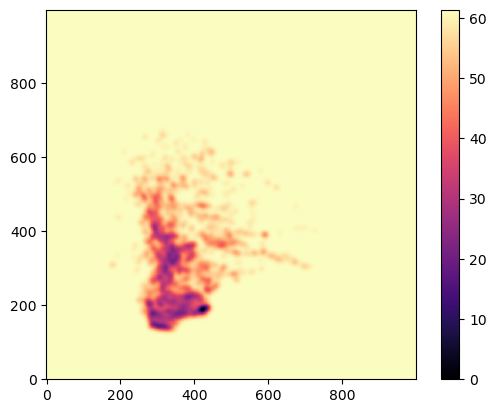

In [7]:
plt.imshow(FE, cmap='magma', norm='linear', aspect='equal', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [8]:
traj = md.load("traj_metad.dcd", top="../equilibrated.pdb")
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [9]:
cv1 = torch.jit.load("cv1.pt")
cv2 = torch.jit.load("cv2.pt")

In [10]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in range(X.shape[0]):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

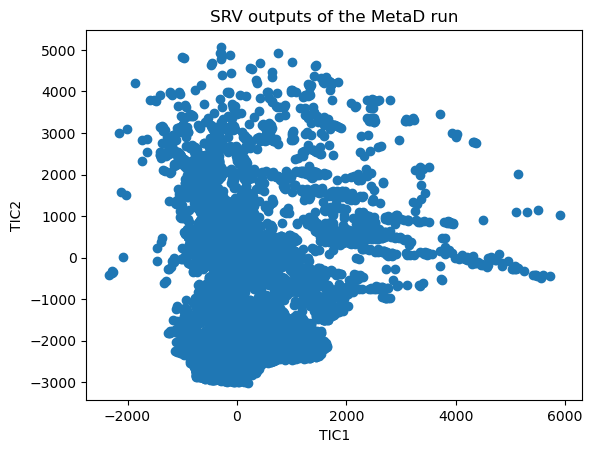

In [11]:
plt.scatter(cv1_vals, cv2_vals)
plt.ylabel("TIC2")
plt.xlabel("TIC1")
plt.title("SRV outputs of the MetaD run")
plt.show()

In [12]:
def get_colvars(traj):
    #CVs = md.compute_distances(traj, [[33, 85], [59, 92]])
    CVs = md.compute_distances(traj, [[30, 88], [30, 95]])
    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(CVs[:, 0], CVs[:, 1], bins=100)

    # Assign count to each point’s bin
    xidx = np.searchsorted(xedges, CVs[:, 0]) - 1
    yidx = np.searchsorted(yedges, CVs[:, 1]) - 1

    # Clip indices to avoid out-of-bounds
    xidx = np.clip(xidx, 0, counts.shape[0] - 1)
    yidx = np.clip(yidx, 0, counts.shape[1] - 1)

    kde = counts[xidx, yidx]
    return CVs, kde

In [13]:
CVs, kds = get_colvars(traj)

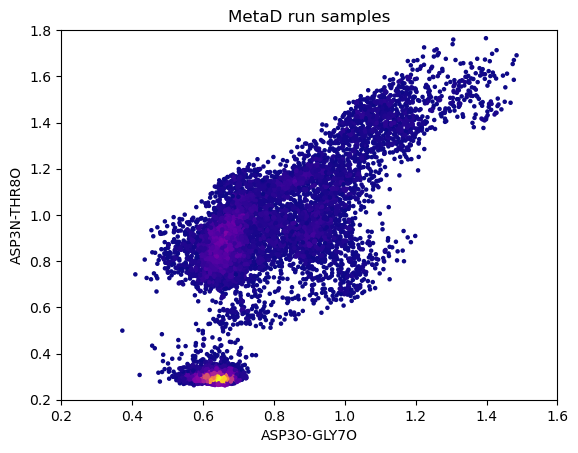

In [14]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
#plt.ylabel("GLU5O-THR8N")
plt.ylabel("ASP3N-THR8O")
#plt.xlabel("ASP3O-GLY7N")
plt.xlabel("ASP3O-GLY7O")
plt.xlim(0.2, 1.6)
plt.ylim(0.2, 1.8)
plt.title("MetaD run samples")
plt.show()

In [15]:
import numpy as np
import pandas as pd

def assign_weights_to_trajectory(bias: np.ndarray,
                                 x_vals: np.ndarray,
                                 y_vals:np.ndarray,
                                 min_x: float, max_x: float,
                                 min_y: float, max_y: float) -> pd.DataFrame:
    """
    Assigns weights from a 2D grid to each (x, y) point in a trajectory based on which grid cell the point falls into.

    Args:
        bias (np.ndarray): 2D array of shape (n_grid_x, n_grid_y) with bias on a regular grid.
        x_vals (np.ndarray): Array of shape (T, ).
        y_vals (np.ndarray): Array of shape (T, ).
        min_x (float): Minimum x value of the grid.
        max_x (float): Maximum x value of the grid.
        min_y (float): Minimum y value of the grid.
        max_y (float): Maximum y value of the grid.

    Returns:
        pd.DataFrame: DataFrame with columns ['x', 'y', 'weight'] for each timestep.
    """
    n_grid_x = bias.shape[0]
    n_grid_y = bias.shape[1]
    # Compute bin width
    dx = (max_x - min_x) / n_grid_x
    dy = (max_y - min_y) / n_grid_y

    # Map coordinates to indices
    ix = np.floor((x_vals - min_x) / dx).astype(int)
    iy = np.floor((y_vals - min_y) / dy).astype(int)

    # Clamp indices to valid range
    ix = np.clip(ix, 0, n_grid_x - 1)
    iy = np.clip(iy, 0, n_grid_y - 1)

    # Extract weights
    bias_vals = bias[ix, iy]
    weights = np.exp(bias_vals/temperature/kB)

    return pd.DataFrame({'CV1': x_vals, 'CV2': y_vals, 'bias': bias_vals, "weight": weights})

In [16]:
data_df = assign_weights_to_trajectory(_totalBias,
                                 cv1_vals.numpy(),
                                 cv2_vals.numpy(),
                                 -5000, 10000,
                                 -5000, 10000)

In [23]:
def get_free_energy_surface(data_df, x, y, temperature, kB):
    # Histogram the weighted trajectory
    hist, x_edges, y_edges = np.histogram2d(data_df[x], data_df[y],
                                            bins=50,
                                            weights=data_df['weight'])

    # Normalize to get probability density
    prob_density = hist / np.sum(hist)

    # Avoid log(0) by setting minimum positive value
    min_nonzero = np.min(prob_density[np.nonzero(prob_density)])
    prob_density[prob_density == 0] = min_nonzero

    # Convert to free energy
    fes = -kB * temperature * np.log(prob_density)

    # with np.errstate(divide='ignore'):  # Suppress warnings for log(0)
    #     fes = -kB * temperature * np.log(prob_density)
    # fes[np.isinf(fes)] = np.inf  # Optional but explicit

    # Optional: set minimum to zero
    fes -= np.min(fes)
    return fes, x_edges, y_edges


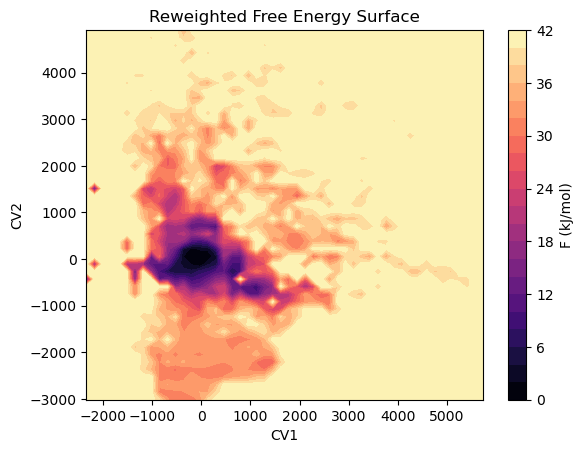

In [24]:
fes, x_edges, y_edges = get_free_energy_surface(data_df, "CV1", "CV2", temperature, kB)
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title("Reweighted Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()

In [25]:
data_df["d1"] = CVs[:, 0]
data_df["d2"] = CVs[:, 1]

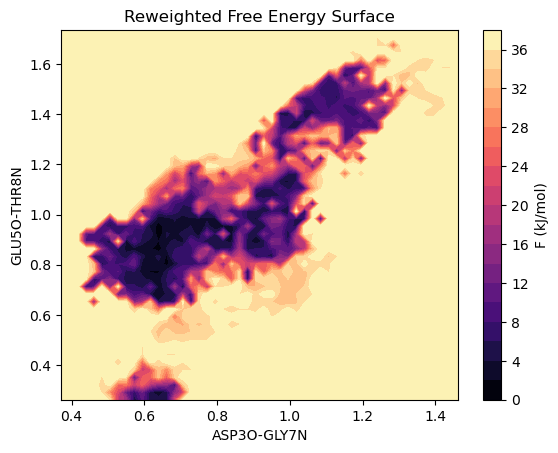

In [26]:
fes, x_edges, y_edges = get_free_energy_surface(data_df, "d1", "d2", temperature, kB)
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
plt.ylabel("GLU5O-THR8N")
plt.xlabel("ASP3O-GLY7N")
plt.title("Reweighted Free Energy Surface")
#plt.xlim(0.2, 1.0)
#plt.ylim(0.2, 1.0)
plt.colorbar(label="F (kJ/mol)")
plt.show()


In [27]:
FE_metad = np.load("/home/armin/Documents/GADES/examples/Chignolin/snrv/metad_FE.npy")

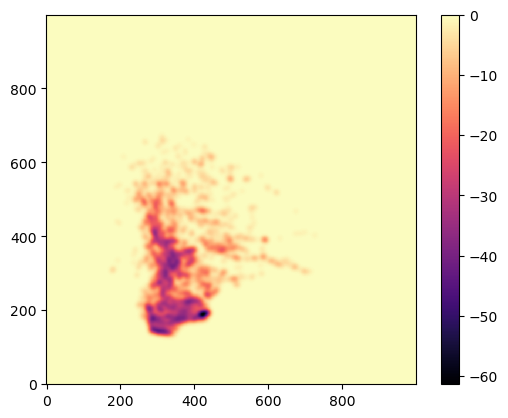

In [28]:
plt.imshow(FE_metad, cmap='magma', norm='linear', aspect='equal', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [29]:
traj = md.load("traj_unbiased.dcd", top="../equilibrated.pdb")
X = torch.from_numpy(traj.xyz)

In [30]:
CVs, kds = get_colvars(traj)

In [31]:
unbiased_df = pd.DataFrame({'CV1': CVs[:, 0], 'CV2': CVs[:, 1], "weight": np.ones(CVs.shape[0], )})

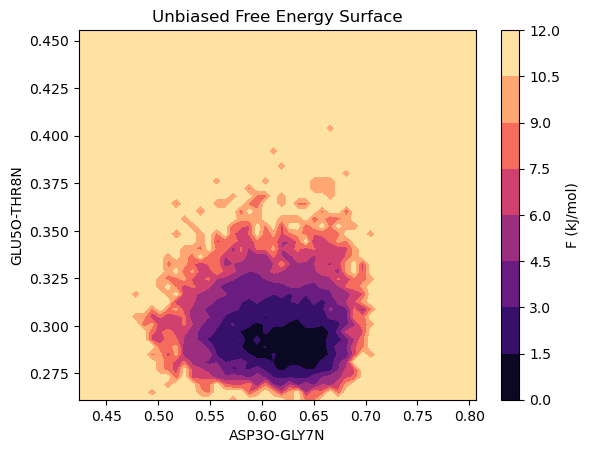

In [32]:
fes, x_edges, y_edges = get_free_energy_surface(unbiased_df, "CV1", "CV2", temperature, kB)
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=10, cmap='magma')
plt.ylabel("GLU5O-THR8N")
plt.xlabel("ASP3O-GLY7N")
plt.title("Unbiased Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()

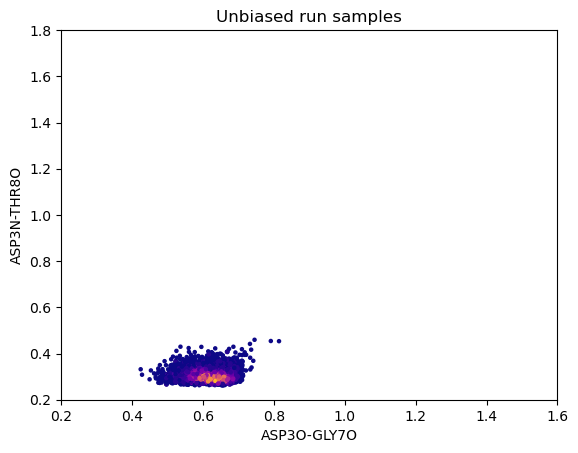

In [33]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
#plt.ylabel("GLU5O-THR8N")
plt.ylabel("ASP3N-THR8O")
#plt.xlabel("ASP3O-GLY7N")
plt.xlabel("ASP3O-GLY7O")
plt.xlim(0.2, 1.6)
plt.ylim(0.2, 1.8)
plt.title("Unbiased run samples")
plt.show()

In [34]:
traj = md.load("../traj_2000_2500.dcd", top="../equilibrated.pdb")
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [35]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in range(X.shape[0]):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

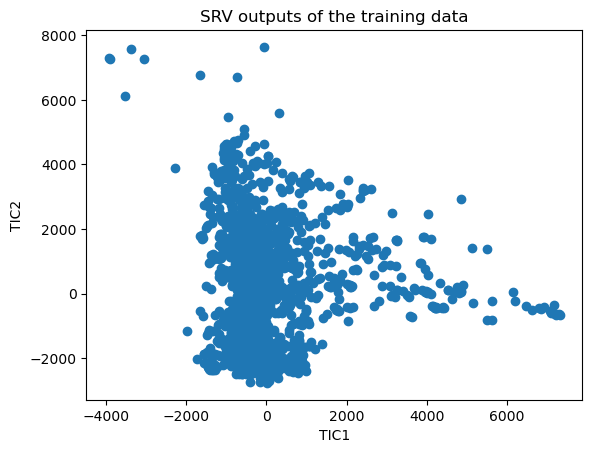

In [36]:
plt.scatter(cv1_vals, cv2_vals)
plt.ylabel("TIC2")
plt.xlabel("TIC1")
plt.title("SRV outputs of the training data")
plt.show()

In [37]:
CVs, kds = get_colvars(traj)

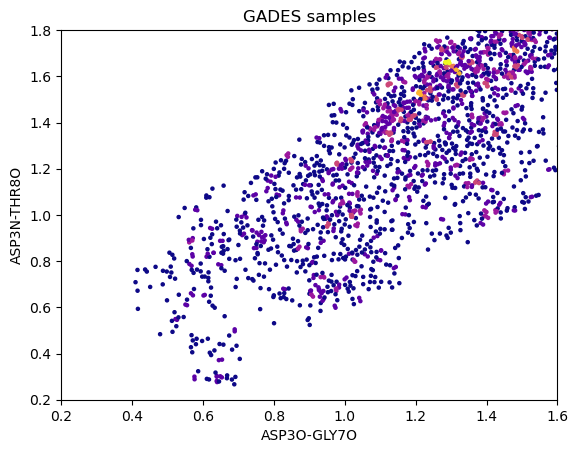

In [38]:
plt.scatter(CVs[:, 0], CVs[:, 1], c=kds, cmap="plasma", s=5)
#plt.ylabel("GLU5O-THR8N")
plt.ylabel("ASP3N-THR8O")
#plt.xlabel("ASP3O-GLY7N")
plt.xlabel("ASP3O-GLY7O")
plt.xlim(0.2, 1.6)
plt.ylim(0.2, 1.8)
plt.title("GADES samples")
plt.show()